In [ ]:
!pip install transformers torch accelerate scikit-learn pandas tqdm
!pip install xgboost

In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [ ]:
model_name = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("FinBERT loaded on:", device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ FinBERT loaded on: cuda


In [ ]:
df = pd.read_csv("news_labels_open_vs_close_h3_tau001.csv")

df = df.dropna()
df = df[df["Article_title"].str.len() > 5]

print("Samples:", len(df))
df.head()


✅ Samples: 452491


,Article_title,Label
0,Agilent Technologies Grows Life Sciences Busin...,0
1,Goldman Sachs Raises Agilent Technologies PT,0
2,J.P. Morgan Reiterates Agilent Technologies Ov...,0
3,"Bank of America Reiterates Buy, $45 PT on Agil...",0
4,JP Morgan Raises PT on Agilent Technologies to...,0


In [ ]:
def finbert_predict_batch(texts, batch_size=32):
    preds = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            labels = torch.argmax(probs, dim=1).cpu().numpy()

        # FinBERT class order: [negative, neutral, positive]
        for l in labels:
            if l == 0:
                preds.append(-1)
            elif l == 1:
                preds.append(0)
            else:
                preds.append(1)

    return np.array(preds)


df["FinBERT_Pred"] = finbert_predict_batch(df["Article_title"].tolist())


100%|██████████| 14141/14141 [04:12<00:00, 56.03it/s]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [ ]:
y_true_close = df["Label"].values
y_pred       = df["FinBERT_Pred"].values

acc_close = accuracy_score(y_true_close, y_pred)
f1_close_macro = f1_score(y_true_close, y_pred, average="macro")
f1_close_weighted = f1_score(y_true_close, y_pred, average="weighted")

print("====== CLOSE LABEL BENCHMARK ======")
print("Accuracy:", acc_close)
print("Macro F1:", f1_close_macro)
print("Weighted F1:", f1_close_weighted)
print(classification_report(y_true_close, y_pred))


====== CLOSE LABEL BENCHMARK ======
Accuracy: 0.2542348908597077
Macro F1: 0.25411100749702037
Weighted F1: 0.2578032453067059
              precision    recall  f1-score   support

          -1       0.27      0.24      0.25    116678
           0       0.56      0.17      0.26    262712
           1       0.16      0.57      0.25     73101

    accuracy                           0.25    452491
   macro avg       0.33      0.33      0.25    452491
weighted avg       0.42      0.25      0.26    452491



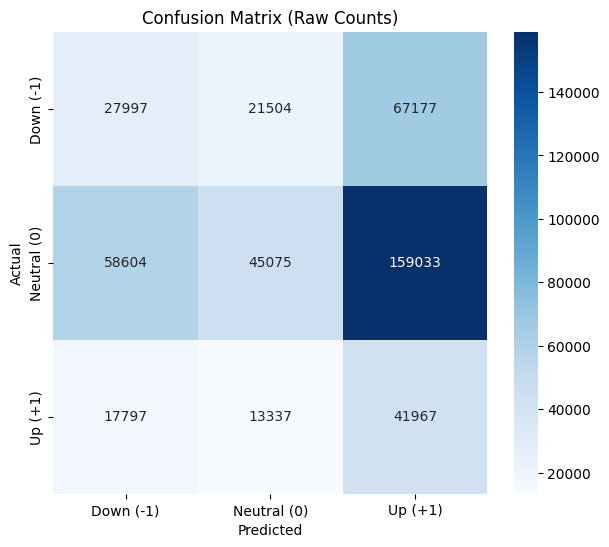

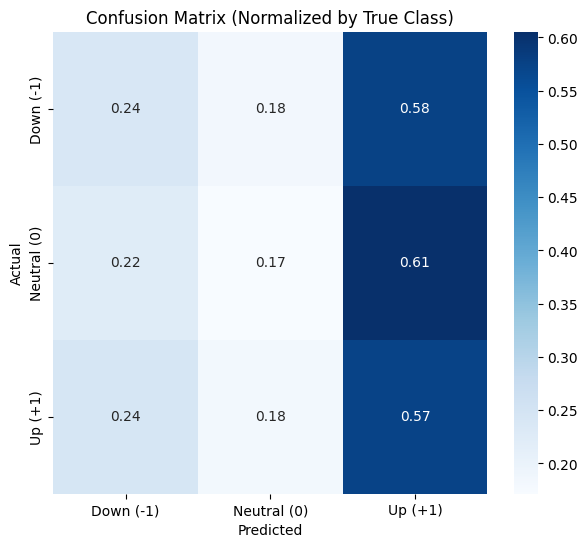

Confusion Matrix (Raw):
[[ 27997  21504  67177]
 [ 58604  45075 159033]
 [ 17797  13337  41967]]

Confusion Matrix (Normalized):
[[0.23995098 0.1843021  0.57574693]
 [0.22307318 0.17157572 0.60535111]
 [0.24345768 0.1824462  0.57409611]]


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


y_true = y_true_close

# 3 classes: -1, 0, +1
labels = [-1, 0, 1]
label_names = ["Down (-1)", "Neutral (0)", "Up (+1)"]

cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Confusion Matrix (Raw):")
print(cm)
print("\nConfusion Matrix (Normalized):")
print(cm_norm)


Fine Turning

In [ ]:
!pip install -U transformers datasets peft accelerate bitsandbytes scikit-learn

In [ ]:
import os
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [ ]:
import pandas as pd

df = pd.read_csv("news_labels_open_vs_close_h3_tau001.csv")
df = df.dropna()
df = df[df["Article_title"].str.len() > 10]

# Convert labels from {-1,0,1} -> {0,1,2}
label_map = {-1:0, 0:1, 1:2}
df["label"] = df["Label"].map(label_map)

print(df["label"].value_counts())
df.head()


label
1    262519
0    116619
2     73051
Name: count, dtype: int64


,Article_title,Label,label
0,Agilent Technologies Grows Life Sciences Busin...,0,1
1,Goldman Sachs Raises Agilent Technologies PT,0,1
2,J.P. Morgan Reiterates Agilent Technologies Ov...,0,1
3,"Bank of America Reiterates Buy, $45 PT on Agil...",0,1
4,JP Morgan Raises PT on Agilent Technologies to...,0,1


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

print(len(train_df), len(test_df))


361751 90438


In [ ]:
import torch
import numpy as np

class_counts = train_df["label"].value_counts().sort_index()
num_samples = len(train_df)
num_classes = 3

class_weights = num_samples / (num_classes * class_counts.values)
class_weights = torch.tensor(class_weights, dtype=torch.float).cuda()

print("Class counts:", class_counts.to_dict())
print("Class weights:", class_weights)


Class counts: {0: 93295, 1: 210015, 2: 58441}
Class weights: tensor([1.2925, 0.5742, 2.0633], device='cuda:0')


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import prepare_model_for_kbit_training

model_name = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    load_in_8bit=True,
    device_map="auto"
)

model = prepare_model_for_kbit_training(model)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()



trainable params: 592,131 || all params: 110,076,678 || trainable%: 0.5379


In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df[["Article_title", "label"]])
test_ds  = Dataset.from_pandas(test_df[["Article_title", "label"]])

def tokenize(batch):
    return tokenizer(
        batch["Article_title"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/361751 [00:00<?, ? examples/s]

Map:   0%|          | 0/90438 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./finbert-lora",
    learning_rate=2e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,

    fp16=False,

    logging_steps=50,

    save_steps=1000,
    save_total_limit=2,

    report_to="none"
)



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted
    }


In [ ]:
from transformers import TrainerCallback

class TrainEvalCallback(TrainerCallback):
    def __init__(self, trainer, train_dataset, eval_dataset, log_steps=500):
        self.trainer = trainer
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.log_steps = log_steps

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.log_steps == 0 and state.global_step > 0:
            print("\n===== METRICS @ step", state.global_step, "=====")

            train_metrics = self.trainer.evaluate(self.train_dataset)
            eval_metrics  = self.trainer.evaluate(self.eval_dataset)

            print("Train Metrics:")
            for k, v in train_metrics.items():
                print(f"  {k}: {v:.4f}")

            print("Validation Metrics:")
            for k, v in eval_metrics.items():
                print(f"  {k}: {v:.4f}")

            print("====================================\n")


In [ ]:
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        **kwargs
    ):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
from transformers import TrainingArguments, Trainer

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()



Step,Training Loss
50,1.098500
100,1.098700
150,1.099100
200,1.097800
250,1.084900
300,1.072800
350,1.062800
400,1.041200
450,1.025800
500,1.025400


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentra

TrainOutput(global_step=8481, training_loss=0.7708844195108286, metrics={'train_runtime': 4073.5897, 'train_samples_per_second': 266.412, 'train_steps_per_second': 2.082, 'total_flos': 7.187968245549312e+16, 'train_loss': 0.7708844195108286, 'epoch': 3.0})

In [ ]:
metrics = trainer.evaluate()
metrics


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'eval_loss': 0.6595034003257751,
 'eval_accuracy': 0.6926402618368385,
 'eval_f1_macro': 0.6568918089985686,
 'eval_f1_weighted': 0.7017216453689606,
 'eval_runtime': 96.9062,
 'eval_samples_per_second': 933.253,
 'eval_steps_per_second': 7.296,
 'epoch': 3.0}

In [ ]:
from google.colab import drive



drive.mount("/content/drive")
from pathlib import Path

DATA = Path("/content/drive/My Drive/EECS Final Project")

Mounted at /content/drive


In [ ]:
trainer.save_model(f"{DATA}/finbert_lora_adapter")
tokenizer.save_pretrained(f"{DATA}/finbert_lora_adapter")


('/content/drive/My Drive/EECS Final Project/finbert_lora_adapter/tokenizer_config.json',
 '/content/drive/My Drive/EECS Final Project/finbert_lora_adapter/special_tokens_map.json',
 '/content/drive/My Drive/EECS Final Project/finbert_lora_adapter/vocab.txt',
 '/content/drive/My Drive/EECS Final Project/finbert_lora_adapter/added_tokens.json',
 '/content/drive/My Drive/EECS Final Project/finbert_lora_adapter/tokenizer.json')

In [ ]:
from peft import PeftModel
model = PeftModel.from_pretrained(base_model, "finbert_lora_adapter")


In [ ]:
import numpy as np

# Run prediction on the TEST set
pred_out = trainer.predict(test_ds)

logits = pred_out.predictions
y_true = pred_out.label_ids
y_pred = np.argmax(logits, axis=1)

print("Prediction shape:", y_pred.shape)
print("True label shape:", y_true.shape)


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Prediction shape: (90438,)
True label shape: (90438,)


In [ ]:
inv_label_map = {0:-1, 1:0, 2:1}

y_true_real = np.array([inv_label_map[x] for x in y_true])
y_pred_real = np.array([inv_label_map[x] for x in y_pred])


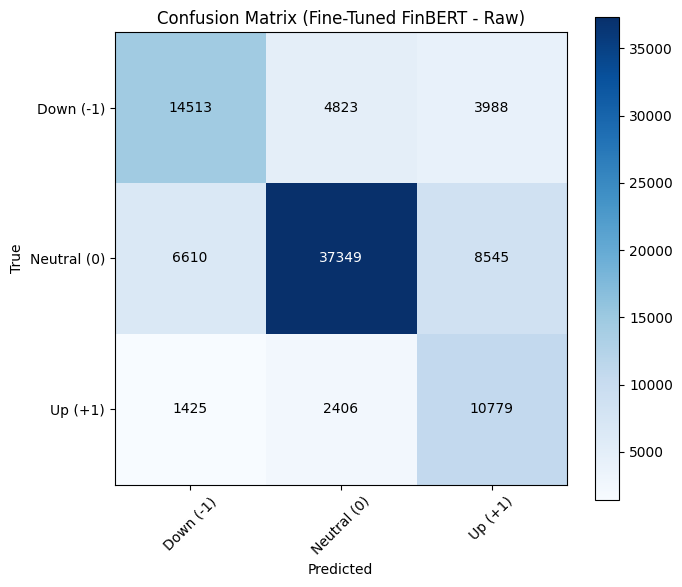

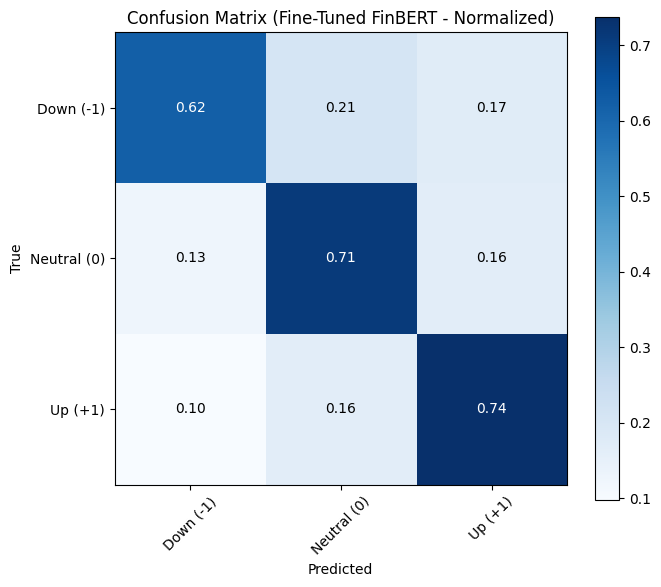

Raw Confusion Matrix:
[[14513  4823  3988]
 [ 6610 37349  8545]
 [ 1425  2406 10779]]

Normalized Confusion Matrix:
[[0.62223461 0.20678271 0.17098268]
 [0.12589517 0.71135533 0.1627495 ]
 [0.09753593 0.16468172 0.73778234]]


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = [-1, 0, 1]
label_names = ["Down (-1)", "Neutral (0)", "Up (+1)"]

cm = confusion_matrix(y_true_real, y_pred_real, labels=labels)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Fine-Tuned FinBERT - Raw)")
plt.colorbar()
plt.xticks(range(3), label_names, rotation=45)
plt.yticks(range(3), label_names)

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,6))
plt.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Fine-Tuned FinBERT - Normalized)")
plt.colorbar()
plt.xticks(range(3), label_names, rotation=45)
plt.yticks(range(3), label_names)

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center",
                 color="white" if cm_norm[i, j] > cm_norm.max()/2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("Raw Confusion Matrix:")
print(cm)

print("\nNormalized Confusion Matrix:")
print(cm_norm)


Topic Modeling

In [ ]:
!pip install scikit-learn

In [ ]:

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

input_csv = "news_labels_open_vs_close_h3_tau001.csv"

df = pd.read_csv(input_csv)

df = df.dropna(subset=["Article_title"])
df = df[df["Article_title"].str.len() > 5].reset_index(drop=True)

print("Number of titles:", len(df))
df.head()


vectorizer = CountVectorizer(
    stop_words="english",
    max_features=50000,
    min_df=5,
    max_df=0.5
)

X = vectorizer.fit_transform(df["Article_title"].values.tolist())
print("Sparse matrix shape:", X.shape)

n_topics = 30

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method="batch",
    random_state=42,
    n_jobs=-1
)

print("Fitting LDA... (this may take a bit on large data)")
lda.fit(X)
print("LDA fitted.")

def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"Topic #{topic_idx}: {' | '.join(top_words)}")

feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words=10)

# topic_dist shape: (num_titles, num_topics)
topic_dist = lda.transform(X)

print("Topic probability matrix shape:", topic_dist.shape)

# Add each topic probability as its own column
for k in range(n_topics):
    df[f"Topic_{k}_Prob"] = topic_dist[:, k]

# Also add dominant topic + its confidence
df["Dominant_Topic"] = topic_dist.argmax(axis=1)
df["Dominant_Topic_Confidence"] = topic_dist.max(axis=1)


# Always keep title
cols_to_keep = ["Article_title"]

# Keep label if it exists in your dataset
if "Label" in df.columns:
    cols_to_keep.append("Label")

# Add all topic probability columns
topic_cols = [f"Topic_{k}_Prob" for k in range(n_topics)]
cols_to_keep += topic_cols

# Add dominant topic info at the end
cols_to_keep += ["Dominant_Topic", "Dominant_Topic_Confidence"]

df_out = df[cols_to_keep].copy()

output_csv = "news_titles_with_topic_matrix.csv"
df_out.to_csv(output_csv, index=False)

print(f"\nSaved FULL topic probability matrix to: {output_csv}")
print("Output shape:", df_out.shape)
print("\nSample rows:")
print(df_out.iloc[:, :12].head())  # preview first few columns

Number of titles: 452491
Sparse matrix shape: (452491, 24660)
Fitting LDA... (this may take a bit on large data)
✅ LDA fitted.
Topic #0: china | oil | industries | sector | performing | picks | fast | wrap | brent | bull
Topic #1: forexlive | petroleum | power | japan | weight | rate | equal | momentum | time | halted
Topic #2: money | cramer | mad | round | lightning | national | value | buying | media | wins
Topic #3: etfs | watch | 2011 | 2012 | 2010 | 2013 | stocks | november | december | june
Topic #4: update | market | shares | higher | markets | mid | trading | lower | following | stocks
Topic #5: says | global | deal | reuters | greece | group | investment | highlights | new | greek
Topic #6: earnings | notable | scheduled | ahead | close | week | open | look | 2014 | thursday
Topic #7: market | losers | gainers | day | pre | stocks | biggest | morning | premarket | winners
Topic #8: initiates | coverage | announces | 00 | pt | capital | outperform | buy | america | session
Top

In [ ]:
import joblib
import os

save_dir = "./topic_model"
os.makedirs(save_dir, exist_ok=True)

# Save LDA model
joblib.dump(lda, os.path.join(save_dir, "lda_model.joblib"))

# Save vectorizer
joblib.dump(vectorizer, os.path.join(save_dir, "count_vectorizer.joblib"))

print("Saved LDA model and vectorizer to:", save_dir)


✅ Saved LDA model and vectorizer to: ./topic_model


In [ ]:

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel


input_csv = "news_titles_with_topic_matrix.csv"
df = pd.read_csv(input_csv)

print("Loaded topic CSV with shape:", df.shape)
print(df.head(2))


base_model_name = "ProsusAI/finbert"
lora_adapter_path = "finbert_lora_adapter"

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=3
).to("cuda")

model = PeftModel.from_pretrained(base_model, lora_adapter_path)
model.eval()

print("Loaded Fine-Tuned FinBERT + LoRA Adapter")

batch_size = 128
titles = df["Article_title"].astype(str).tolist()

all_probs = []

with torch.no_grad():
    for i in tqdm(range(0, len(titles), batch_size), desc="Running FinBERT inference"):
        batch_titles = titles[i:i + batch_size]

        encoded = tokenizer(
            batch_titles,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to("cuda")

        outputs = model(**encoded)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)


all_probs = np.vstack(all_probs)

print("Probability matrix shape:", all_probs.shape)
# Expected shape: (num_titles, 3)


df["FinBERT_Prob_Down"]    = all_probs[:, 0]
df["FinBERT_Prob_Neutral"] = all_probs[:, 1]
df["FinBERT_Prob_Up"]      = all_probs[:, 2]


output_csv = "news_with_topics_and_finbert_probabilities.csv"
df.to_csv(output_csv, index=False)

print(f"\nSaved final dataset with FinBERT probabilities to: {output_csv}")
print("Final shape:", df.shape)
print(df[[
    "Article_title",
    "FinBERT_Prob_Down",
    "FinBERT_Prob_Neutral",
    "FinBERT_Prob_Up"
]].head())


✅ Loaded topic CSV with shape: (452491, 34)
                                       Article_title  Label  Topic_0_Prob  \
0  Agilent Technologies Grows Life Sciences Busin...      0      0.003030   
1       Goldman Sachs Raises Agilent Technologies PT      0      0.004762   

   Topic_1_Prob  Topic_2_Prob  Topic_3_Prob  Topic_4_Prob  Topic_5_Prob  \
0      0.003030      0.003030      0.003030      0.003030      0.003030   
1      0.004762      0.004762      0.004762      0.004762      0.004762   

   Topic_6_Prob  Topic_7_Prob  ...  Topic_22_Prob  Topic_23_Prob  \
0      0.003030      0.003030  ...       0.003030       0.003030   
1      0.004762      0.004762  ...       0.004762       0.004762   

   Topic_24_Prob  Topic_25_Prob  Topic_26_Prob  Topic_27_Prob  Topic_28_Prob  \
0       0.003030       0.003030       0.003030       0.003030       0.429455   
1       0.004762       0.004762       0.004762       0.004762       0.004762   

   Topic_29_Prob  Dominant_Topic  Dominant_Topic_Con

Running FinBERT inference: 100%|██████████| 3536/3536 [04:14<00:00, 13.87it/s]


✅ Probability matrix shape: (452491, 3)

✅ Saved final dataset with FinBERT probabilities to: news_with_topics_and_finbert_probabilities.csv
✅ Final shape: (452491, 37)
                                       Article_title  FinBERT_Prob_Down  \
0  Agilent Technologies Grows Life Sciences Busin...           0.011433   
1       Goldman Sachs Raises Agilent Technologies PT           0.013564   
2  J.P. Morgan Reiterates Agilent Technologies Ov...           0.040570   
3  Bank of America Reiterates Buy, $45 PT on Agil...           0.014194   
4  JP Morgan Raises PT on Agilent Technologies to...           0.013585   

   FinBERT_Prob_Neutral  FinBERT_Prob_Up  
0              0.979368         0.009199  
1              0.981096         0.005341  
2              0.949494         0.009936  
3              0.982346         0.003460  
4              0.983197         0.003218  


GXBoost

Raw shape: (452491, 37)
                                       Article_title  Label  Topic_0_Prob  \
0  Agilent Technologies Grows Life Sciences Busin...      0      0.003030   
1       Goldman Sachs Raises Agilent Technologies PT      0      0.004762   
2  J.P. Morgan Reiterates Agilent Technologies Ov...      0      0.004167   

   Topic_1_Prob  Topic_2_Prob  Topic_3_Prob  Topic_4_Prob  Topic_5_Prob  \
0      0.003030      0.003030      0.003030      0.003030      0.003030   
1      0.004762      0.004762      0.004762      0.004762      0.004762   
2      0.004167      0.004167      0.004167      0.004167      0.004167   

   Topic_6_Prob  Topic_7_Prob  ...  Topic_25_Prob  Topic_26_Prob  \
0      0.003030      0.003030  ...       0.003030       0.003030   
1      0.004762      0.004762  ...       0.004762       0.004762   
2      0.004167      0.004167  ...       0.004167       0.004167   

   Topic_27_Prob  Topic_28_Prob  Topic_29_Prob  Dominant_Topic  \
0       0.003030       0.42

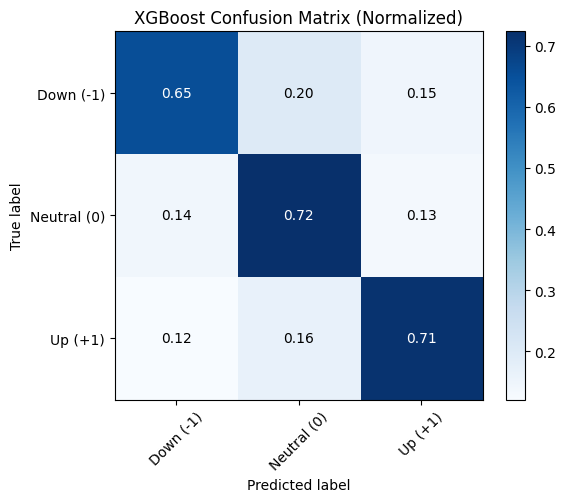

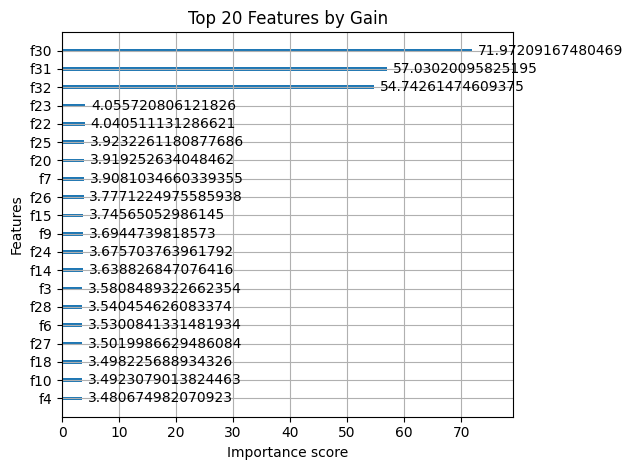

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
import matplotlib.pyplot as plt

csv_path = "news_with_topics_and_finbert_probabilities.csv"
df = pd.read_csv(csv_path)

print("Raw shape:", df.shape)
print(df.head(3))

df = df.dropna(subset=["Label"])
print("After dropping missing Label:", df.shape)


label_map = {-1: 0, 0: 1, 1: 2}
inv_label_map = {v: k for k, v in label_map.items()}

df["label_idx"] = df["Label"].map(label_map)

print("Label distribution (original):")
print(df["Label"].value_counts().sort_index())
print("\nLabel distribution (indexed):")
print(df["label_idx"].value_counts().sort_index())


feature_cols = [
    c for c in df.columns
    if c.startswith("Topic_") or c.startswith("FinBERT_Prob_")
]

print("\nUsing", len(feature_cols), "features:")
print(feature_cols[:10], "...")

X = df[feature_cols].values
y = df["label_idx"].values


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTrain size:", X_train.shape[0])
print("Test  size:", X_test.shape[0])

class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total = len(y_train)

class_weights = total / (num_classes * class_counts)
print("\nClass counts:", class_counts)
print("Class weights:", class_weights)

sample_weight = class_weights[y_train]


tree_method = "hist"

model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    tree_method=tree_method,

    max_depth=6,
    learning_rate=0.05,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train,
    y_train,
    sample_weight=sample_weight,
    eval_set=eval_set,
    verbose=50  # print eval metric every 50 trees
)


probs_test = model.predict_proba(X_test)  # shape: (N_test, 3)
y_pred = probs_test.argmax(axis=1)

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("\n====== XGBoost 3-Class Results ======")
print(f"Accuracy:     {acc:.4f}")
print(f"Macro F1:     {macro_f1:.4f}")
print(f"Weighted F1:  {weighted_f1:.4f}")

target_names = ["Down (-1)", "Neutral (0)", "Up (+1)"]
print("\nClassification report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    digits=4
))


cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

print("Confusion matrix (raw):")
print(cm)

print("\nConfusion matrix (normalized by true class):")
print(cm_norm)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix (Normalized)")
plt.colorbar()
plt.xticks([0,1,2], target_names, rotation=45)
plt.yticks([0,1,2], target_names)

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center",
                 va="center",
                 color="white" if cm_norm[i, j] > cm_norm.max()/2 else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

xgb.plot_importance(model, max_num_features=20, importance_type="gain")
plt.title("Top 20 Features by Gain")
plt.tight_layout()
plt.show()


NPL

TensorFlow version: 2.19.0
Raw shape: (452491, 37)
Label distribution:
label_idx
0    116678
1    262712
2     73101
Name: count, dtype: int64
Using 33 features
Train: (289593, 33)
Val:   (72399, 33)
Test:  (90499, 33)
Class counts: [ 74673 168135  46785]
Class weights: {0: np.float64(1.2927162428186896), 1: np.float64(0.5741279329110536), 2: np.float64(2.0632895158704714)}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               8704      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout 

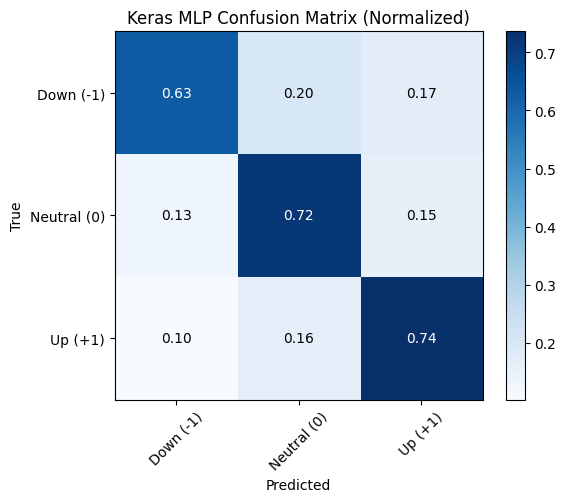

In [ ]:
!pip install tensorflow scikit-learn

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


csv_path = "news_with_topics_and_finbert_probabilities.csv"
df = pd.read_csv(csv_path)

print("Raw shape:", df.shape)

# Drop rows without label
df = df.dropna(subset=["Label"])

# Map labels: {-1, 0, +1} → {0,1,2}
label_map = {-1: 0, 0: 1, 1: 2}
inv_label_map = {0: -1, 1: 0, 2: 1}

df["label_idx"] = df["Label"].map(label_map)

print("Label distribution:")
print(df["label_idx"].value_counts().sort_index())


feature_cols = [
    c for c in df.columns
    if c.startswith("Topic_") or c.startswith("FinBERT_Prob_")
]

print("Using", len(feature_cols), "features")

X = df[feature_cols].values.astype(np.float32)
y = df["label_idx"].values.astype(np.int64)


X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.20,
    stratify=y_trainval,
    random_state=42
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total = len(y_train)

class_weights = {
    i: total / (num_classes * class_counts[i])
    for i in range(num_classes)
}

print("Class counts:", class_counts)
print("Class weights:", class_weights)


D = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(D,)),

    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

class MacroF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
        macro_f1 = f1_score(self.y_val, y_pred, average="macro")
        print(f" — val_macro_f1: {macro_f1:.4f}")


callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    MacroF1Callback(X_val, y_val)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=1024,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)


probs_test = model.predict(X_test)
y_pred = probs_test.argmax(axis=1)

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("\n====== KERAS MLP RESULTS (TEST SET) ======")
print(f"Accuracy:     {acc:.4f}")
print(f"Macro F1:     {macro_f1:.4f}")
print(f"Weighted F1:  {weighted_f1:.4f}")

target_names = ["Down (-1)", "Neutral (0)", "Up (+1)"]
print("\nClassification report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    digits=4
))


cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

print("Confusion Matrix (raw):")
print(cm)

print("\nConfusion Matrix (normalized):")
print(cm_norm)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.title("Keras MLP Confusion Matrix (Normalized)")
plt.colorbar()
plt.xticks([0,1,2], target_names, rotation=45)
plt.yticks([0,1,2], target_names)

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center",
                 va="center",
                 color="white" if cm_norm[i, j] > cm_norm.max()/2 else "black")

plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


Topics Only

Raw shape: (452491, 37)
After dropping missing Label: (452491, 37)

Label distribution:
label_idx
0    116678
1    262712
2     73101
Name: count, dtype: int64

Using ONLY topic features: 30

Train size: (361992, 30)
Test  size: (90499, 30)

Class counts: [ 93342 210169  58481]
Class weights: [1.29270853 0.57412844 2.06330261]
[0]	validation_0-mlogloss:1.09736	validation_1-mlogloss:1.09743
[50]	validation_0-mlogloss:1.07045	validation_1-mlogloss:1.07343
[100]	validation_0-mlogloss:1.06259	validation_1-mlogloss:1.06785
[150]	validation_0-mlogloss:1.05789	validation_1-mlogloss:1.06500
[200]	validation_0-mlogloss:1.05430	validation_1-mlogloss:1.06307
[250]	validation_0-mlogloss:1.05106	validation_1-mlogloss:1.06140
[300]	validation_0-mlogloss:1.04815	validation_1-mlogloss:1.05998
[350]	validation_0-mlogloss:1.04500	validation_1-mlogloss:1.05849
[400]	validation_0-mlogloss:1.04231	validation_1-mlogloss:1.05733
[450]	validation_0-mlogloss:1.03965	validation_1-mlogloss:1.05613
[499]	validati

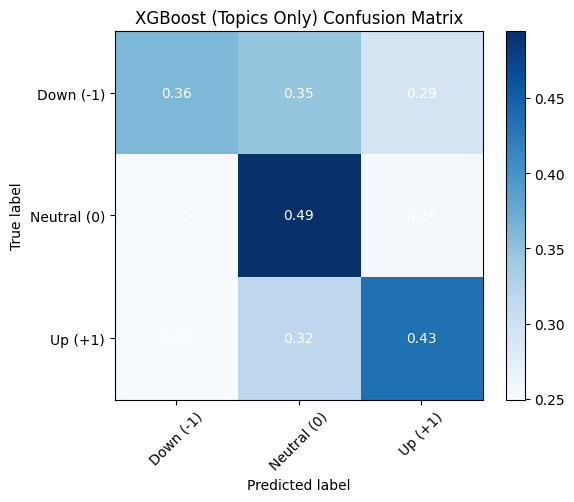

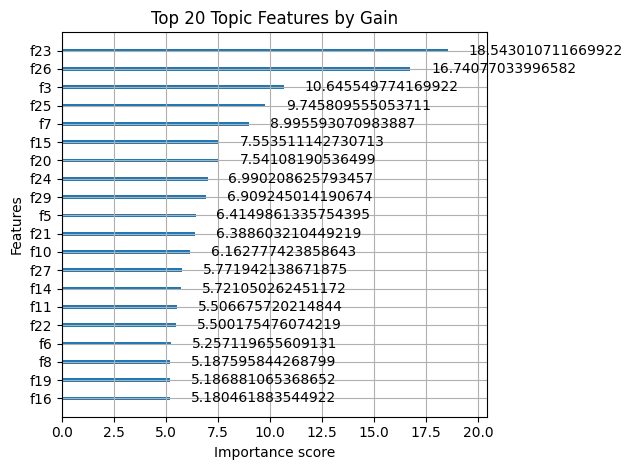

In [ ]:


!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
import matplotlib.pyplot as plt



csv_path = "news_with_topics_and_finbert_probabilities.csv"
df = pd.read_csv(csv_path)

print("Raw shape:", df.shape)

# Drop rows without label
df = df.dropna(subset=["Label"])
print("After dropping missing Label:", df.shape)



label_map = {-1: 0, 0: 1, 1: 2}
inv_label_map = {0: -1, 1: 0, 2: 1}

df["label_idx"] = df["Label"].map(label_map)

print("\nLabel distribution:")
print(df["label_idx"].value_counts().sort_index())



topic_cols = [c for c in df.columns if c.startswith("Topic_") and c.endswith("_Prob")]
print("\nUsing ONLY topic features:", len(topic_cols))

X = df[topic_cols].values
y = df["label_idx"].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTrain size:", X_train.shape)
print("Test  size:", X_test.shape)


class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total = len(y_train)

class_weights = total / (num_classes * class_counts)
sample_weight = class_weights[y_train]

print("\nClass counts:", class_counts)
print("Class weights:", class_weights)


model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    tree_method="hist",
    max_depth=6,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train,
    y_train,
    sample_weight=sample_weight,
    eval_set=eval_set,
    verbose=50
)


probs_test = model.predict_proba(X_test)
y_pred = probs_test.argmax(axis=1)

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("\n====== XGBOOST (TOPICS ONLY) RESULTS ======")
print(f"Accuracy:     {acc:.4f}")
print(f"Macro F1:     {macro_f1:.4f}")
print(f"Weighted F1:  {weighted_f1:.4f}")

target_names = ["Down (-1)", "Neutral (0)", "Up (+1)"]
print("\nClassification report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    digits=4
))


cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

print("Confusion Matrix (raw):")
print(cm)

print("\nConfusion Matrix (normalized):")
print(cm_norm)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("XGBoost (Topics Only) Confusion Matrix")
plt.colorbar()
plt.xticks([0,1,2], target_names, rotation=45)
plt.yticks([0,1,2], target_names)

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center",
                 va="center",
                 color="white" if cm_norm[i, j] > cm_norm.max()/2 else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


xgb.plot_importance(model, max_num_features=20, importance_type="gain")
plt.title("Top 20 Topic Features by Gain")
plt.tight_layout()
plt.show()


In [ ]:
model.save_model("xgb_topics_only.json")
print("XGBoost model saved to xgb_topics_only.json")


✅ XGBoost model saved to xgb_topics_only.json


In [ ]:
topic_cols = [c for c in df.columns if c.startswith("Topic_") and c.endswith("_Prob")]

with open("xgb_topics_only_features.txt", "w") as f:
    for col in topic_cols:
        f.write(col + "\n")

print("Saved topic feature list to xgb_topics_only_features.txt")


Saved topic feature list to xgb_topics_only_features.txt


Hypbrid


In [ ]:
!pip install tensorflow scikit-learn xgboost joblib


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import xgboost as xgb
import matplotlib.pyplot as plt


In [ ]:
csv_path = "news_with_topics_and_finbert_probabilities.csv"
df = pd.read_csv(csv_path)

print("Raw shape:", df.shape)

# Keep only valid labels
df = df.dropna(subset=["Label"])

# Map labels {-1,0,1} → {0,1,2}
label_map = {-1: 0, 0: 1, 1: 2}
inv_label_map = {0: -1, 1: 0, 2: 1}

df["label_idx"] = df["Label"].map(label_map)

print("Label distribution:")
print(df["label_idx"].value_counts().sort_index())


Raw shape: (452491, 37)
Label distribution:
label_idx
0    116678
1    262712
2     73101
Name: count, dtype: int64


In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model("xgb_topics_only.json")

print("Loaded Topics-Only XGBoost model")


✅ Loaded Topics-Only XGBoost model


In [ ]:
with open("xgb_topics_only_features.txt") as f:
    topic_cols = [line.strip() for line in f.readlines()]

print("Loaded topic feature order:", len(topic_cols))


✅ Loaded topic feature order: 30


In [ ]:
X_topics = df[topic_cols].values
xgb_probs = xgb_model.predict_proba(X_topics)

df["XGB_Prob_Down"]    = xgb_probs[:, 0]
df["XGB_Prob_Neutral"] = xgb_probs[:, 1]
df["XGB_Prob_Up"]      = xgb_probs[:, 2]

print("Added XGBoost probability features")


✅ Added XGBoost probability features


In [ ]:
stack_features = [
    "XGB_Prob_Down", "XGB_Prob_Neutral", "XGB_Prob_Up",
    "FinBERT_Prob_Down", "FinBERT_Prob_Neutral", "FinBERT_Prob_Up"
]

X = df[stack_features].values.astype(np.float32)
y = df["label_idx"].values.astype(np.int64)

print("Final stacked feature shape:", X.shape)


Final stacked feature shape: (452491, 6)


In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.20,
    stratify=y_trainval,
    random_state=42
)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


In [ ]:
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total = len(y_train)

class_weights = {
    i: total / (num_classes * class_counts[i])
    for i in range(num_classes)
}

print("Class weights:", class_weights)


Class weights: {0: np.float64(1.2927162428186896), 1: np.float64(0.5741279329110536), 2: np.float64(2.0632895158704714)}


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(6,)),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                448       
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                     

In [ ]:
class MacroF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
        macro_f1 = f1_score(self.y_val, y_pred, average="macro")
        print(f" — val_macro_f1: {macro_f1:.4f}")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=1024,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        ),
        MacroF1Callback(X_val, y_val)
    ],
    verbose=2
)


Epoch 1/40
 — val_macro_f1: 0.6711
283/283 - 7s - loss: 0.7318 - accuracy: 0.6642 - val_loss: 0.6656 - val_accuracy: 0.7051 - 7s/epoch - 26ms/step
Epoch 2/40
 — val_macro_f1: 0.6702
283/283 - 5s - loss: 0.6702 - accuracy: 0.7038 - val_loss: 0.6625 - val_accuracy: 0.7043 - 5s/epoch - 17ms/step
Epoch 3/40
 — val_macro_f1: 0.6714
283/283 - 5s - loss: 0.6636 - accuracy: 0.7070 - val_loss: 0.6580 - val_accuracy: 0.7053 - 5s/epoch - 17ms/step
Epoch 4/40
 — val_macro_f1: 0.6704
283/283 - 5s - loss: 0.6618 - accuracy: 0.7063 - val_loss: 0.6585 - val_accuracy: 0.7038 - 5s/epoch - 17ms/step
Epoch 5/40
 — val_macro_f1: 0.6723
283/283 - 5s - loss: 0.6595 - accuracy: 0.7069 - val_loss: 0.6578 - val_accuracy: 0.7059 - 5s/epoch - 18ms/step
Epoch 6/40
 — val_macro_f1: 0.6717
283/283 - 5s - loss: 0.6580 - accuracy: 0.7061 - val_loss: 0.6548 - val_accuracy: 0.7065 - 5s/epoch - 19ms/step
Epoch 7/40
 — val_macro_f1: 0.6693
283/283 - 5s - loss: 0.6562 - accuracy: 0.7067 - val_loss: 0.6605 - val_accuracy: 0

In [ ]:
probs_test = model.predict(X_test)
y_pred = probs_test.argmax(axis=1)

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("\n====== STACKED MLP RESULTS ======")
print(f"Accuracy:     {acc:.4f}")
print(f"Macro F1:     {macro_f1:.4f}")
print(f"Weighted F1:  {weighted_f1:.4f}")

target_names = ["Down (-1)", "Neutral (0)", "Up (+1)"]
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))


2829/2829 [==============================] - 4s 1ms/step

====== STACKED MLP RESULTS ======
Accuracy:     0.6968
Macro F1:     0.6605
Weighted F1:  0.7052

Classification report:
              precision    recall  f1-score   support

   Down (-1)     0.6375    0.6293    0.6334     23336
 Neutral (0)     0.8392    0.7174    0.7735     52543
     Up (+1)     0.4737    0.7304    0.5747     14620

    accuracy                         0.6968     90499
   macro avg     0.6501    0.6924    0.6605     90499
weighted avg     0.7281    0.6968    0.7052     90499



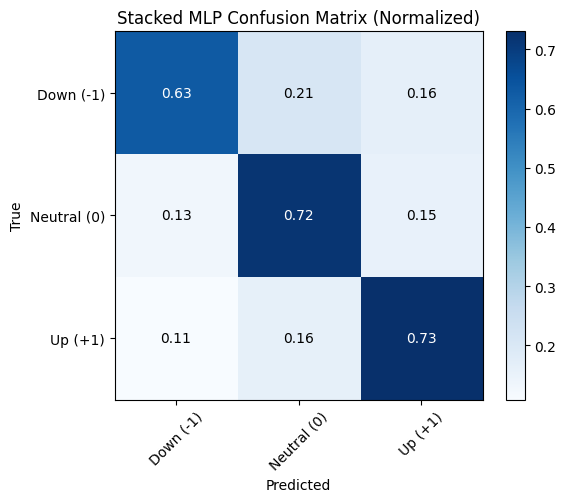

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.title("Stacked MLP Confusion Matrix (Normalized)")
plt.colorbar()
plt.xticks([0,1,2], target_names, rotation=45)
plt.yticks([0,1,2], target_names)

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center",
                 va="center",
                 color="white" if cm_norm[i, j] > cm_norm.max()/2 else "black")

plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


XGBOOST hybrid


In [ ]:
csv_path = "news_with_topics_and_finbert_probabilities.csv"
df = pd.read_csv(csv_path)

print("Raw shape:", df.shape)

df = df.dropna(subset=["Label"])

# Map labels {-1,0,1} → {0,1,2}
label_map = {-1: 0, 0: 1, 1: 2}
inv_label_map = {0: -1, 1: 0, 2: 1}

df["label_idx"] = df["Label"].map(label_map)

print("Label distribution:")
print(df["label_idx"].value_counts().sort_index())


Raw shape: (452491, 37)
Label distribution:
label_idx
0    116678
1    262712
2     73101
Name: count, dtype: int64


In [ ]:
xgb_topics = xgb.XGBClassifier()
xgb_topics.load_model("xgb_topics_only.json")

print("Loaded Topics-Only XGBoost model")


✅ Loaded Topics-Only XGBoost model


In [ ]:
topic_cols = [c for c in df.columns if c.startswith("Topic_") and c.endswith("_Prob")]

X_topics = df[topic_cols].values
xgb_topic_probs = xgb_topics.predict_proba(X_topics)

df["XGB_Prob_Down"]    = xgb_topic_probs[:, 0]
df["XGB_Prob_Neutral"] = xgb_topic_probs[:, 1]
df["XGB_Prob_Up"]      = xgb_topic_probs[:, 2]

print("Added XGBoost topic probabilities")


✅ Added XGBoost topic probabilities


In [ ]:
stack_features = [
    "XGB_Prob_Down", "XGB_Prob_Neutral", "XGB_Prob_Up",
    "FinBERT_Prob_Down", "FinBERT_Prob_Neutral", "FinBERT_Prob_Up"
]

X = df[stack_features].values
y = df["label_idx"].values

print("Final stacked feature shape:", X.shape)


Final stacked feature shape: (452491, 6)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (361992, 6)
Test size: (90499, 6)


In [ ]:
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total = len(y_train)

class_weights = total / (num_classes * class_counts)
sample_weight = class_weights[y_train]

print("Class counts:", class_counts)
print("Class weights:", class_weights)


Class counts: [ 93342 210169  58481]
Class weights: [1.29270853 0.57412844 2.06330261]


In [ ]:
stacked_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    tree_method="hist",
    max_depth=4,
    learning_rate=0.05,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0
)

eval_set = [(X_train, y_train), (X_test, y_test)]

stacked_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weight,
    eval_set=eval_set,
    verbose=50
)


[0]	validation_0-mlogloss:1.06785	validation_1-mlogloss:1.06809
[50]	validation_0-mlogloss:0.67030	validation_1-mlogloss:0.67753
[100]	validation_0-mlogloss:0.64604	validation_1-mlogloss:0.65691
[150]	validation_0-mlogloss:0.64264	validation_1-mlogloss:0.65560
[200]	validation_0-mlogloss:0.64119	validation_1-mlogloss:0.65539
[250]	validation_0-mlogloss:0.64008	validation_1-mlogloss:0.65517
[300]	validation_0-mlogloss:0.63922	validation_1-mlogloss:0.65508
[350]	validation_0-mlogloss:0.63832	validation_1-mlogloss:0.65485
[399]	validation_0-mlogloss:0.63772	validation_1-mlogloss:0.65487


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [ ]:
probs_test = stacked_model.predict_proba(X_test)
y_pred = probs_test.argmax(axis=1)

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("\n====== STACKED XGBOOST RESULTS ======")
print(f"Accuracy:     {acc:.4f}")
print(f"Macro F1:     {macro_f1:.4f}")
print(f"Weighted F1:  {weighted_f1:.4f}")

target_names = ["Down (-1)", "Neutral (0)", "Up (+1)"]
print("\nClassification report:")
print(classification_report(
    y_test, y_pred,
    target_names=target_names,
    digits=4
))



====== STACKED XGBOOST RESULTS ======
Accuracy:     0.6985
Macro F1:     0.6631
Weighted F1:  0.7062

Classification report:
              precision    recall  f1-score   support

   Down (-1)     0.6110    0.6538    0.6317     23336
 Neutral (0)     0.8407    0.7159    0.7733     52543
     Up (+1)     0.4977    0.7075    0.5843     14620

    accuracy                         0.6985     90499
   macro avg     0.6498    0.6924    0.6631     90499
weighted avg     0.7260    0.6985    0.7062     90499



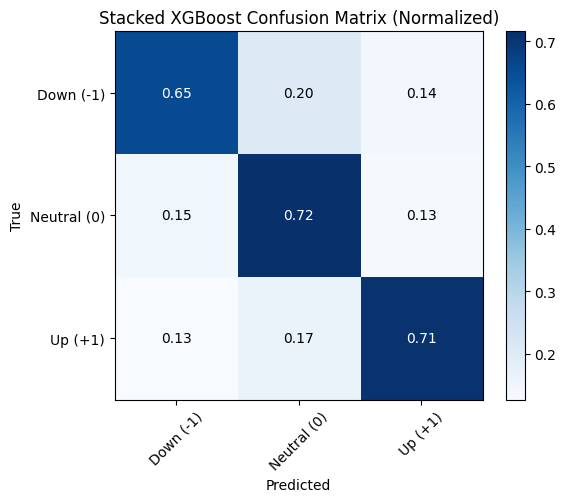

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.title("Stacked XGBoost Confusion Matrix (Normalized)")
plt.colorbar()
plt.xticks([0,1,2], target_names, rotation=45)
plt.yticks([0,1,2], target_names)

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if cm_norm[i, j] > cm_norm.max()/2 else "black")

plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


In [ ]:
stacked_model.save_model("xgb_stacked_topic_finbert.json")
print("Saved stacked XGBoost model")



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

target_names = ["Down (-1)", "Neutral (0)", "Up (+1)"]

def evaluate_set(name, model, X, y_true):
    probs = model.predict_proba(X)
    y_pred = probs.argmax(axis=1)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"\n===== {name.upper()} SET METRICS =====")
    print(f"Accuracy:     {acc:.4f}")
    print(f"Macro F1:     {macro_f1:.4f}")
    print(f"Weighted F1:  {weighted_f1:.4f}")

    print("\nClassification report:")
    print(classification_report(
        y_true, y_pred,
        target_names=target_names,
        digits=4
    ))

    # ----- Confusion Matrix -----
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    print("Confusion Matrix (raw):")
    print(cm)

    print("Confusion Matrix (normalized):")
    print(cm_norm)

    # ----- Plot normalized CM -----
    plt.figure(figsize=(5, 4))
    plt.imshow(cm_norm, cmap=plt.cm.Blues)
    plt.title(f"{name} Set Confusion Matrix (Normalized)")
    plt.colorbar()
    plt.xticks([0,1,2], target_names, rotation=45)
    plt.yticks([0,1,2], target_names)

    for i in range(3):
        for j in range(3):
            plt.text(
                j, i, f"{cm_norm[i, j]:.2f}",
                ha="center", va="center",
                color="white" if cm_norm[i, j] > cm_norm.max()/2 else "black"
            )

    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    return acc, macro_f1, weighted_f1



===== TRAIN SET METRICS =====
Accuracy:     0.7083
Macro F1:     0.6750
Weighted F1:  0.7157

Classification report:
              precision    recall  f1-score   support

   Down (-1)     0.6240    0.6713    0.6468     93342
 Neutral (0)     0.8476    0.7200    0.7786    210169
     Up (+1)     0.5110    0.7255    0.5996     58481

    accuracy                         0.7083    361992
   macro avg     0.6608    0.7056    0.6750    361992
weighted avg     0.7355    0.7083    0.7157    361992

Confusion Matrix (raw):
[[ 62661  18203  12478]
 [ 30722 151327  28120]
 [  7040   9015  42426]]
Confusion Matrix (normalized):
[[0.67130552 0.19501403 0.13368044]
 [0.1461776  0.72002531 0.13379709]
 [0.12038098 0.15415263 0.72546639]]


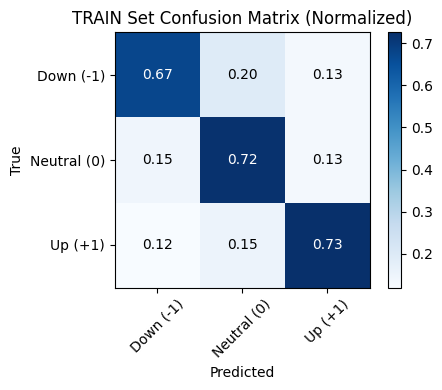


===== VALIDATION SET METRICS =====
Accuracy:     0.6587
Macro F1:     0.6357
Weighted F1:  0.6730

Classification report:
              precision    recall  f1-score   support

   Down (-1)     0.6003    0.6716    0.6340     18669
 Neutral (0)     0.8835    0.6148    0.7250     42034
     Up (+1)     0.4181    0.7958    0.5482     11696

    accuracy                         0.6587     72399
   macro avg     0.6340    0.6941    0.6357     72399
weighted avg     0.7353    0.6587    0.6730     72399

Confusion Matrix (raw):
[[12539  2379  3751]
 [ 6990 25841  9203]
 [ 1358  1030  9308]]
Confusion Matrix (normalized):
[[0.67164819 0.1274305  0.20092131]
 [0.16629395 0.61476424 0.21894181]
 [0.11610807 0.0880643  0.79582763]]


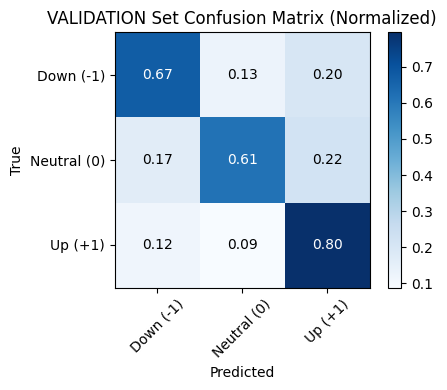


===== TEST SET METRICS =====
Accuracy:     0.6985
Macro F1:     0.6631
Weighted F1:  0.7062

Classification report:
              precision    recall  f1-score   support

   Down (-1)     0.6110    0.6538    0.6317     23336
 Neutral (0)     0.8407    0.7159    0.7733     52543
     Up (+1)     0.4977    0.7075    0.5843     14620

    accuracy                         0.6985     90499
   macro avg     0.6498    0.6924    0.6631     90499
weighted avg     0.7260    0.6985    0.7062     90499

Confusion Matrix (raw):
[[15257  4711  3368]
 [ 7855 37615  7073]
 [ 1857  2419 10344]]
Confusion Matrix (normalized):
[[0.65379671 0.20187693 0.14432636]
 [0.1494966  0.71588984 0.13461355]
 [0.12701778 0.16545828 0.70752394]]


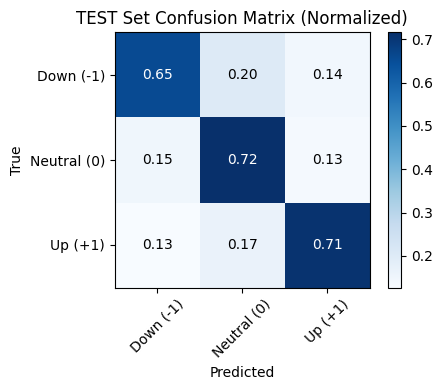

In [ ]:
train_metrics = evaluate_set("TRAIN", stacked_model, X_train, y_train)
val_metrics   = evaluate_set("VALIDATION", stacked_model, X_val, y_val)
test_metrics  = evaluate_set("TEST", stacked_model, X_test, y_test)
